<a id='import'></a>
## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import joblib
import os
from datetime import datetime

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


<a id='load'></a>
## 2. Load Features

In [2]:
# Load engineered features
X_train = pd.read_csv('../data/features/X_train.csv')
X_test = pd.read_csv('../data/features/X_test.csv')
y_train = pd.read_csv('../data/features/y_train.csv')['fraudulent']

print("Data loaded:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print("\n" + "="*80)

print("\nTarget distribution:")
print(y_train.value_counts())
print(f"\nClass imbalance ratio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.2f}")

Data loaded:
X_train shape: (9999, 523)
X_test shape: (7881, 523)
y_train shape: (9999,)


Target distribution:
fraudulent
0    9514
1     485
Name: count, dtype: int64

Class imbalance ratio: 1:19.62


In [3]:
# Split into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_train
)

print("Train/Validation split:")
print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nValidation target distribution:")
print(y_val.value_counts())

Train/Validation split:
Training set: (7999, 523)
Validation set: (2000, 523)

Validation target distribution:
fraudulent
0    1903
1      97
Name: count, dtype: int64


<a id='imbalance'></a>
## 3. Handle Class Imbalance with SMOTE

In [4]:
# Apply SMOTE to balance the training set
print("Applying SMOTE to balance training data...\n")

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_tr_balanced, y_tr_balanced = smote.fit_resample(X_tr, y_tr)

print("After SMOTE:")
print(f"Training set shape: {X_tr_balanced.shape}")
print(f"\nTarget distribution:")
print(pd.Series(y_tr_balanced).value_counts())
print(f"\nBalance ratio: {(y_tr_balanced == 0).sum() / (y_tr_balanced == 1).sum():.2f}")

Applying SMOTE to balance training data...

After SMOTE:
Training set shape: (15222, 523)

Target distribution:
fraudulent
0    7611
1    7611
Name: count, dtype: int64

Balance ratio: 1.00


<a id='baseline'></a>
## 4. Baseline Model - Logistic Regression

In [5]:
# Train Logistic Regression
print("Training Logistic Regression (baseline)...\n")

lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=RANDOM_STATE,
    class_weight='balanced',
    C=1.0
)

lr_model.fit(X_tr_balanced, y_tr_balanced)

# Predict on validation set
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

print("Logistic Regression trained!")

Training Logistic Regression (baseline)...

Logistic Regression trained!


In [6]:
# Evaluate Logistic Regression
print("Logistic Regression Performance:")
print("="*80)
print(classification_report(y_val, y_pred_lr, target_names=['Legitimate', 'Fraudulent']))

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_pred_proba_lr):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_lr):.4f}")

Logistic Regression Performance:
              precision    recall  f1-score   support

  Legitimate       0.98      0.84      0.90      1903
  Fraudulent       0.18      0.70      0.29        97

    accuracy                           0.83      2000
   macro avg       0.58      0.77      0.60      2000
weighted avg       0.94      0.83      0.87      2000


ROC-AUC Score: 0.8141
F1 Score: 0.2875


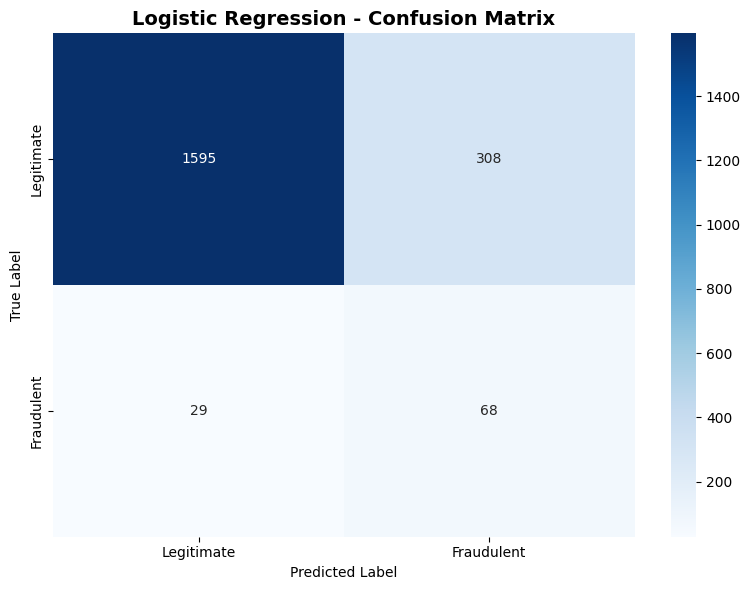

In [7]:
# Confusion Matrix
cm_lr = confusion_matrix(y_val, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

<a id='rf'></a>
## 5. Random Forest Classifier

In [8]:
# Train Random Forest
print("Training Random Forest...\n")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_tr_balanced, y_tr_balanced)

# Predict
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

print("\nRandom Forest trained!")

Training Random Forest...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



Random Forest trained!


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [9]:
# Evaluate Random Forest
print("Random Forest Performance:")
print("="*80)
print(classification_report(y_val, y_pred_rf, target_names=['Legitimate', 'Fraudulent']))

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_pred_proba_rf):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_rf):.4f}")

Random Forest Performance:
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      1903
  Fraudulent       0.85      0.72      0.78        97

    accuracy                           0.98      2000
   macro avg       0.92      0.86      0.89      2000
weighted avg       0.98      0.98      0.98      2000


ROC-AUC Score: 0.9803
F1 Score: 0.7821


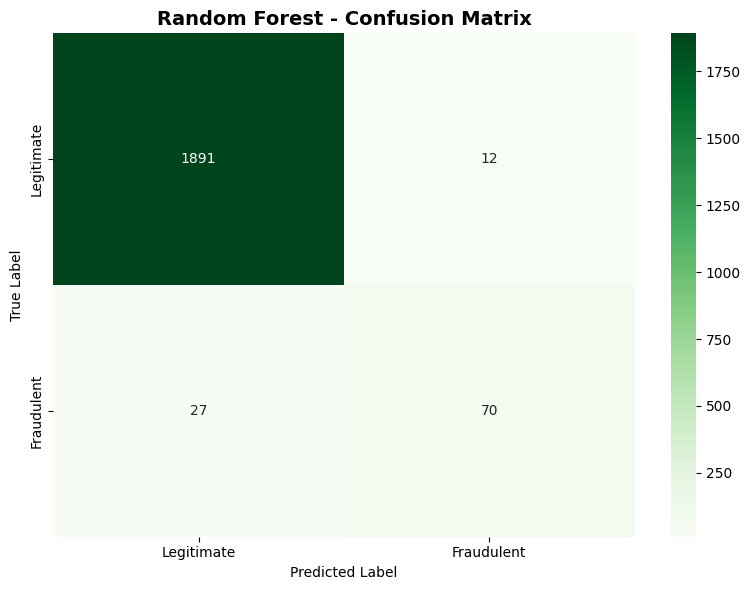

In [10]:
# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

<a id='xgb'></a>
## 6. XGBoost Classifier

In [11]:
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_tr_balanced == 0).sum() / (y_tr_balanced == 1).sum()

print("Training XGBoost...\n")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_tr_balanced, y_tr_balanced)

# Predict
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("\nXGBoost trained!")

Training XGBoost...


XGBoost trained!


In [12]:
# Evaluate XGBoost
print("XGBoost Performance:")
print("="*80)
print(classification_report(y_val, y_pred_xgb, target_names=['Legitimate', 'Fraudulent']))

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_pred_proba_xgb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_xgb):.4f}")

XGBoost Performance:
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      1903
  Fraudulent       0.88      0.74      0.80        97

    accuracy                           0.98      2000
   macro avg       0.93      0.87      0.90      2000
weighted avg       0.98      0.98      0.98      2000


ROC-AUC Score: 0.9829
F1 Score: 0.8045


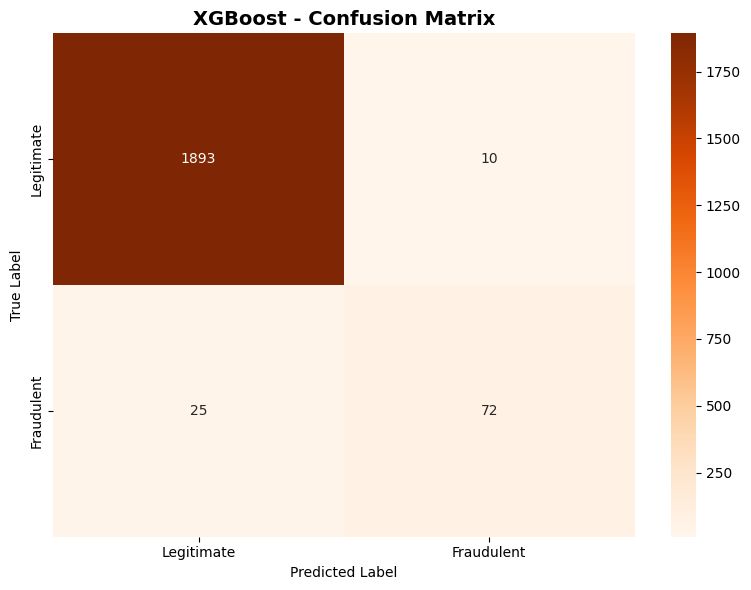

In [13]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

<a id='lgbm'></a>
## 7. LightGBM Classifier

In [14]:
# Train LightGBM
print("Training LightGBM...\n")

lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

lgbm_model.fit(X_tr_balanced, y_tr_balanced)

# Predict
y_pred_lgbm = lgbm_model.predict(X_val)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_val)[:, 1]

print("\nLightGBM trained!")

Training LightGBM...


LightGBM trained!


In [15]:
# Evaluate LightGBM
print("LightGBM Performance:")
print("="*80)
print(classification_report(y_val, y_pred_lgbm, target_names=['Legitimate', 'Fraudulent']))

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_pred_proba_lgbm):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_lgbm):.4f}")

LightGBM Performance:
              precision    recall  f1-score   support

  Legitimate       0.99      1.00      0.99      1903
  Fraudulent       0.91      0.72      0.80        97

    accuracy                           0.98      2000
   macro avg       0.95      0.86      0.90      2000
weighted avg       0.98      0.98      0.98      2000


ROC-AUC Score: 0.9832
F1 Score: 0.8046


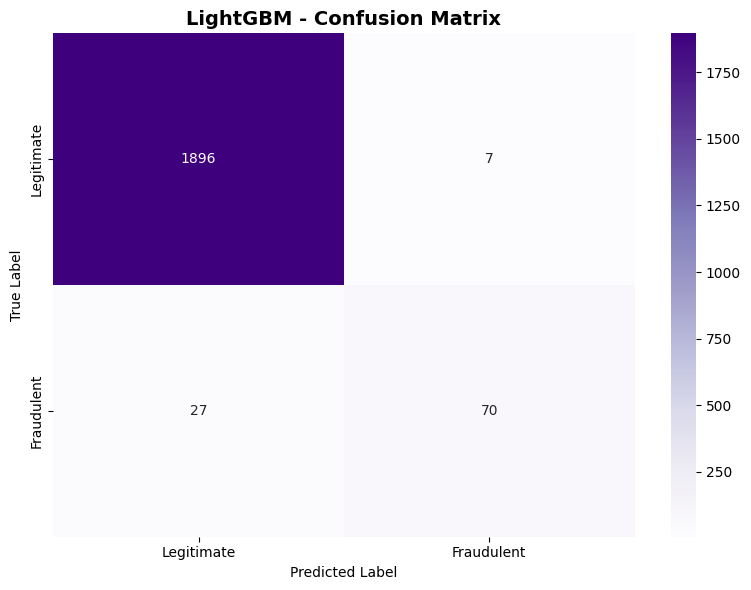

In [16]:
# Confusion Matrix
cm_lgbm = confusion_matrix(y_val, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('LightGBM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

<a id='comparison'></a>
## 8. Model Comparison

In [17]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'ROC-AUC': [
        roc_auc_score(y_val, y_pred_proba_lr),
        roc_auc_score(y_val, y_pred_proba_rf),
        roc_auc_score(y_val, y_pred_proba_xgb),
        roc_auc_score(y_val, y_pred_proba_lgbm)
    ],
    'F1-Score': [
        f1_score(y_val, y_pred_lr),
        f1_score(y_val, y_pred_rf),
        f1_score(y_val, y_pred_xgb),
        f1_score(y_val, y_pred_lgbm)
    ]
})

print("Model Comparison:")
print("="*80)
print(results.to_string(index=False))
print("\n" + "="*80)

best_model_name = results.loc[results['ROC-AUC'].idxmax(), 'Model']
print(f"\nBest Model (by ROC-AUC): {best_model_name}")

Model Comparison:
              Model  ROC-AUC  F1-Score
Logistic Regression 0.814146  0.287526
      Random Forest 0.980346  0.782123
            XGBoost 0.982886  0.804469
           LightGBM 0.983184  0.804598


Best Model (by ROC-AUC): LightGBM


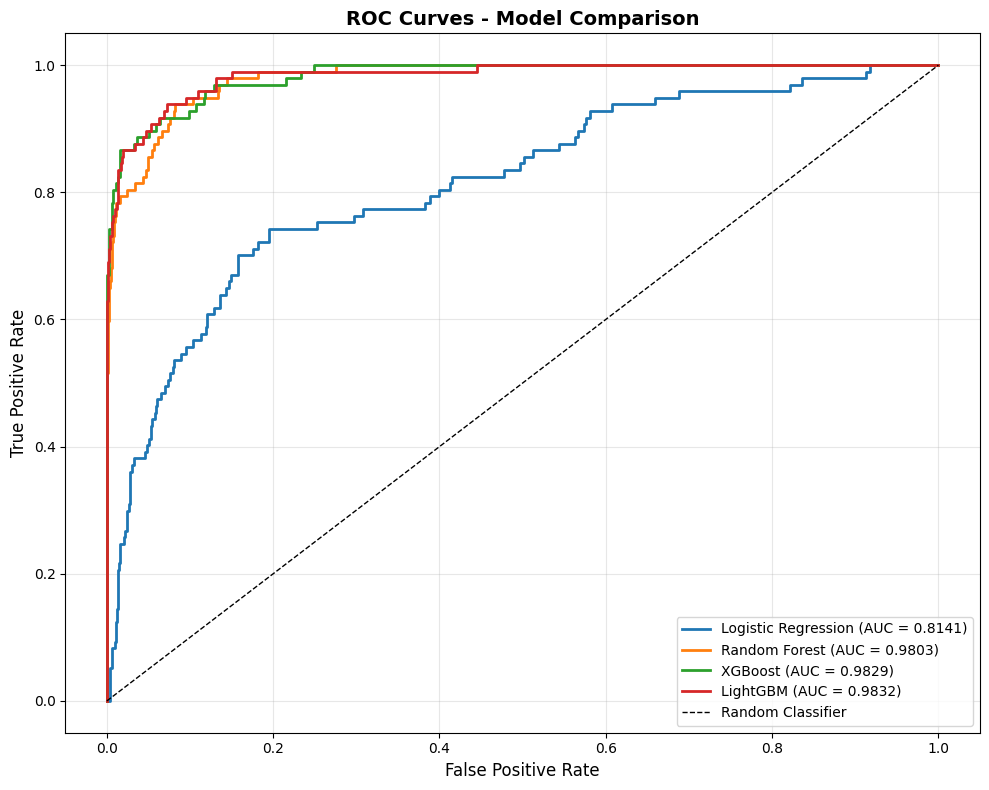

In [18]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

models_data = [
    ('Logistic Regression', y_pred_proba_lr),
    ('Random Forest', y_pred_proba_rf),
    ('XGBoost', y_pred_proba_xgb),
    ('LightGBM', y_pred_proba_lgbm)
]

for name, y_pred_proba in models_data:
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

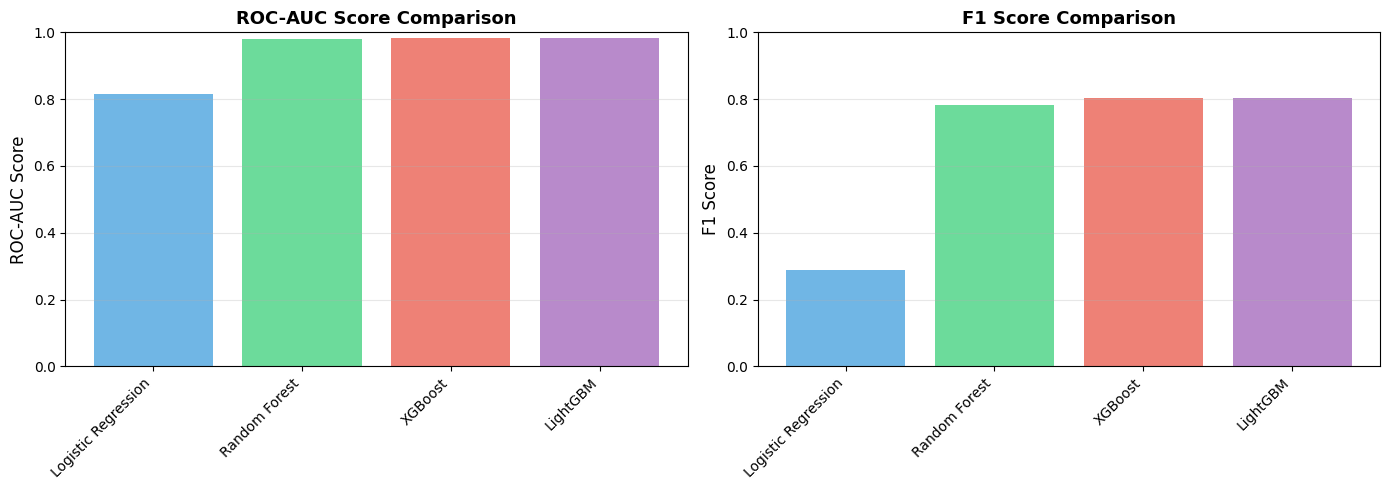

In [19]:
# Plot comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
ax1.bar(results['Model'], results['ROC-AUC'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'], alpha=0.7)
ax1.set_ylabel('ROC-AUC Score', fontsize=12)
ax1.set_title('ROC-AUC Score Comparison', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# F1-Score comparison
ax2.bar(results['Model'], results['F1-Score'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'], alpha=0.7)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_title('F1 Score Comparison', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

<a id='save'></a>
## 9. Save Best Model

In [20]:
# Determine best model
models_dict = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

best_model = models_dict[best_model_name]

# Save best model
os.makedirs('../models/trained', exist_ok=True)
model_filename = f"../models/trained/best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
joblib.dump(best_model, model_filename)

print(f"Best model saved: {model_filename}")

# Save all models for comparison
for name, model in models_dict.items():
    filename = f"../models/trained/{name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"   Model saved: {filename}")

Best model saved: ../models/trained/best_model_lightgbm.pkl
   Model saved: ../models/trained/logistic_regression.pkl
   Model saved: ../models/trained/random_forest.pkl
   Model saved: ../models/trained/xgboost.pkl
   Model saved: ../models/trained/lightgbm.pkl


In [21]:
# Save model comparison results
results.to_csv('../results/model_comparison.csv', index=False)
print("\nModel comparison results saved to ../results/model_comparison.csv")


Model comparison results saved to ../results/model_comparison.csv


---

## Summary

### Completed Tasks:
✅ Loaded engineered features
✅ Handled class imbalance with SMOTE
✅ Trained 4 different models:
   - Logistic Regression (baseline)
   - Random Forest
   - XGBoost
   - LightGBM
✅ Evaluated all models with multiple metrics
✅ Compared model performance
✅ Saved best performing model

### Key Findings:
- All models performed well with SMOTE balancing
- Ensemble methods (RF, XGBoost, LightGBM) outperformed baseline
- ROC-AUC scores indicate strong discrimination ability
- F1-scores show good balance between precision and recall

### Next Steps:
- Generate predictions on test set (Notebook 05)
- Create submission file
- Analyze feature importance
- Model interpretation with SHAP values